# Probability map  over the 5000 x 5000 pixels images 

## Import needed packages

In [12]:
import os
import pandas as pd
import numpy as np
from glob import glob
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import tensorflow as tf

## Load the images

In [2]:
base_dir = './data/Kather_texture_2016_larger_images_10/'

In [3]:
df = pd.DataFrame({'path': glob(os.path.join(base_dir, '*.tif'))})

In [4]:
df['image'] = df['path'].map(plt.imread)

In [5]:
df.head()

path  \
0  ./data/Kather_texture_2016_larger_images_10/CR...   
1  ./data/Kather_texture_2016_larger_images_10/CR...   
2  ./data/Kather_texture_2016_larger_images_10/CR...   
3  ./data/Kather_texture_2016_larger_images_10/CR...   
4  ./data/Kather_texture_2016_larger_images_10/CR...   

                                               image  
0  [[[153, 85, 132], [154, 92, 139], [153, 91, 13...  
1  [[[71, 24, 68], [69, 18, 59], [74, 23, 64], [7...  
2  [[[147, 110, 154], [150, 118, 167], [143, 111,...  
3  [[[177, 124, 166], [189, 137, 176], [202, 150,...  
4  [[[79, 20, 52], [62, 13, 42], [63, 14, 43], [6...

In [6]:
df['image'].iloc[1].shape

(5000, 5000, 3)

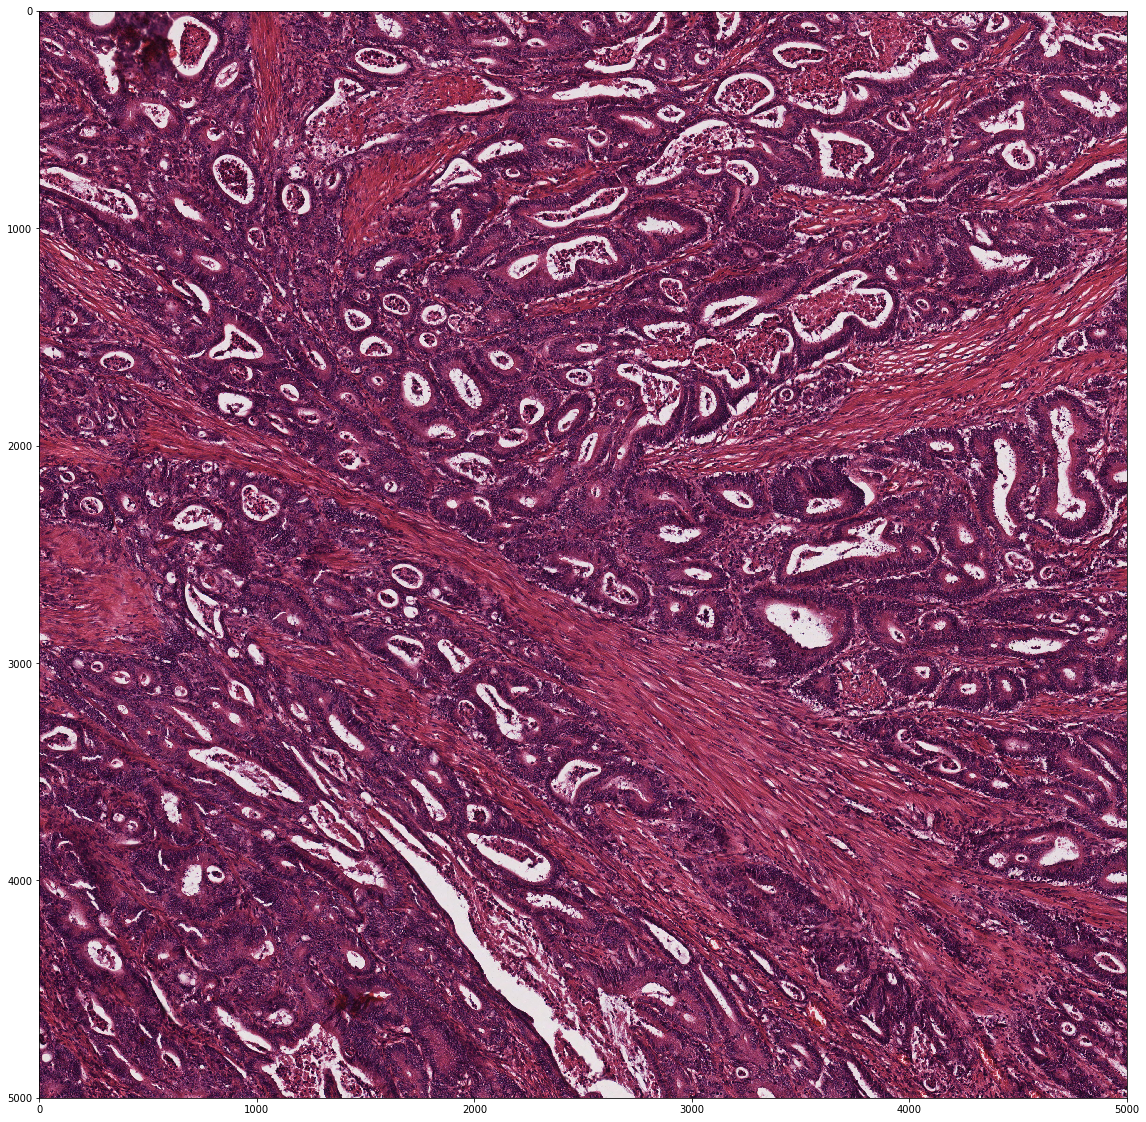

In [7]:
# define the size of the image
fig,ax = plt.subplots(figsize=(20,20))

# display the image
ax.imshow(df['image'].iloc[1])
plt.show()

## Load Model with the best validation accuracy

In [13]:
# best model
best_model='./results/model_vgg16_v4.weights.best.hdf5'

# load the weights with the best validation accuracy
best_model = tf.keras.models.load_model(best_model)

## Create a sliding window to cover the full images

In [8]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

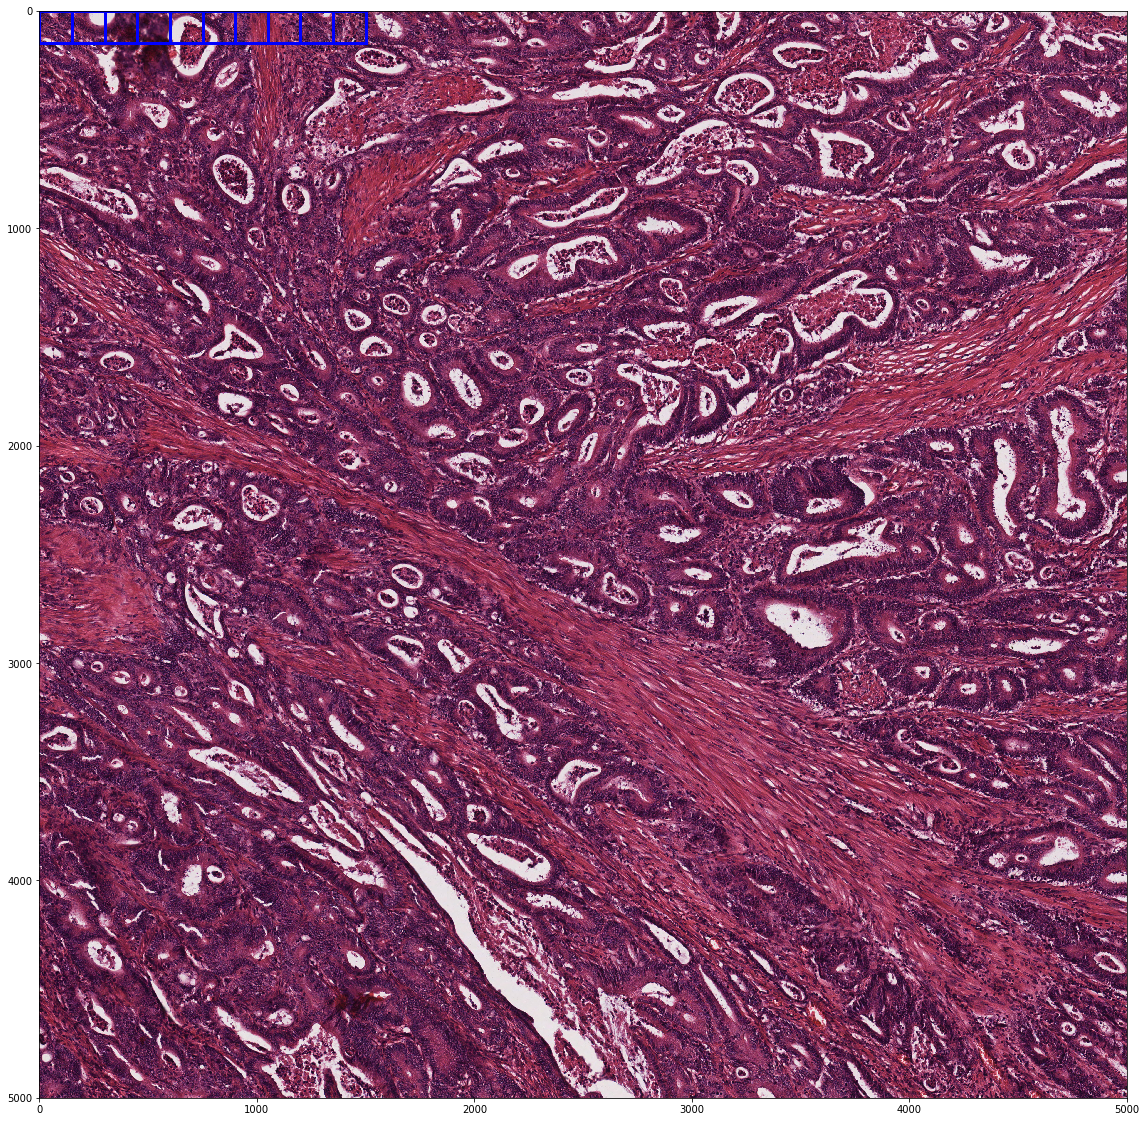

In [9]:
# define the size the the window
(winW, winH) = (150, 150)

# define the sie of the image
fig,ax = plt.subplots(figsize=(20,20))

# define a counter to limit the number of iteration
n=0

# display the image
plt.imshow(df['image'].iloc[1])

for (x, y, window) in sliding_window(df['image'].iloc[1], 150, (winW, winH)):
    
        # (x, y) ------
        # |           |
        # |           |
        # |           |
        # -------- (x + winW, y + winH)

        # count the number of iteration
        n+=1
        
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        
        # only display the first 10 sliding windows
        if n>10:
            break
 
        # since we do not have a classifier, we'll just draw the window
        print('number of sliding window:',n, 'coordinate:',(x, y), (x + winW, y + winH)) 
        
        # get the current reference
        ax = plt.gca()

        # create a Rectangle patch
        rect = patches.Rectangle((x, y),winW,winH, linewidth=3, edgecolor='b', facecolor='none')
        
        # add the patch to the axes
        ax.add_patch(rect)
        
        # diplay the image and the rectangles
        display.clear_output(wait=True)
        display.display(plt.gcf())
        #time.sleep(0.025)

# To avoid duplicate plots at the end        
plt.close()

## Use the sliding window to get prediction for each sub image

In [32]:
# define the size the the window
(winW, winH) = (150, 150)

# define a counter to limit the number of iteration
n=0

# define the sie of the image
fig,ax = plt.subplots(figsize=(20,20))

# define an empty numpy array for the predictions
pred = np.zeros(shape=(5000,5000))
pred3=[]

for (x, y, window) in sliding_window(df['image'].iloc[1], 150, (winW, winH)):
    
        # (x, y) ------
        # |           |
        # |           |
        # |           |
        # -------- (x + winW, y + winH)

        # count the number of iteration
        n+=1
        
        # If the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        
        # transform the data
        input_data=np.expand_dims(window,axis=0)
        input_data = np.array(input_data, dtype=np.float32)
        input_data /= 255
        
        # get the prediction
        predicion=np.argmax(best_model.predict(input_data))
        pred[y:y + winH,x:x + winW]=np.argmax(best_model.predict(input_data))
        
        if n<10:
            # printsome info for the first 10 sliding windows
            print('Sliding window n0:',n, 'coordinate:',(x, y), (x + winW, y + winH) ,'shape:',window.shape, 'prediction:',predicion) 

print('')
print('Total number of sliding windows:',n)

sliding window n0: 1 coordinate: (0, 0) (150, 150) shape: (150, 150, 3) prediction: 1
sliding window n0: 2 coordinate: (150, 0) (300, 150) shape: (150, 150, 3) prediction: 7
sliding window n0: 3 coordinate: (300, 0) (450, 150) shape: (150, 150, 3) prediction: 2
sliding window n0: 4 coordinate: (450, 0) (600, 150) shape: (150, 150, 3) prediction: 7
sliding window n0: 5 coordinate: (600, 0) (750, 150) shape: (150, 150, 3) prediction: 7
sliding window n0: 6 coordinate: (750, 0) (900, 150) shape: (150, 150, 3) prediction: 7
sliding window n0: 7 coordinate: (900, 0) (1050, 150) shape: (150, 150, 3) prediction: 6
sliding window n0: 8 coordinate: (1050, 0) (1200, 150) shape: (150, 150, 3) prediction: 1
sliding window n0: 9 coordinate: (1200, 0) (1350, 150) shape: (150, 150, 3) prediction: 7

Total number of sliding windows: 1156


## Display the probability map

In [54]:
dict_label=['ADIPOSE',
            'COMPLEX',
            'DEBRIS',
            'EMPTY',
            'LYMPHO',
            'MUCOSA',
            'STROMA',
            'TUMOR']

In [64]:
# discrete color scheme
#cmap = ListedColormap(['white', 'red', 'orange', 'yellow', 'black', 'green', 'blue', 'violet'])
cmap = ListedColormap(['pink', 'purple', 'deeppink', 'lavenderblush', 'darkorchid', 'orchid', 'hotpink', 'darkslateblue'])

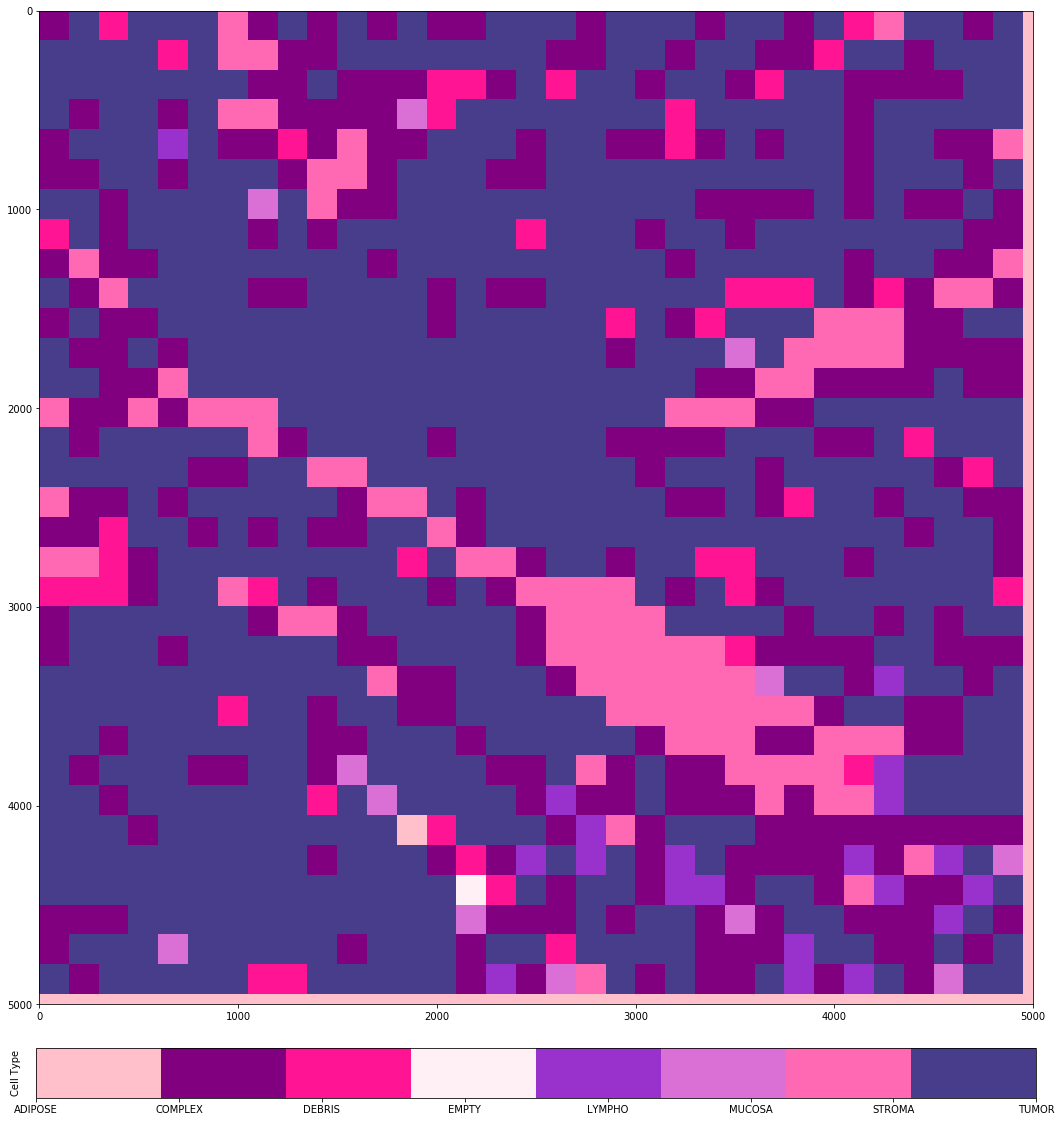

In [65]:
fig,ax = plt.subplots(figsize=(20,20))

im = ax.imshow(pred, cmap=cmap)
#im = ax.imshow(pred, interpolation='nearest', cmap=plt.cm.Blues)
cbar = plt.colorbar(im, cmap=cmap, ticks=[0,1,2,3,4,5,6,7], orientation='horizontal', fraction=0.046, pad=0.04)

cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Cell Type')
#cbar.ax.get_yaxis().set_ticks([0,1,2,3,4,5,6,7])
#cbar.set_ticklabels(['tot', 'red', 'orange', 'yellow', 'black', 'green', 'blue', 'violet'])
cbar.set_ticklabels(dict_label)
plt.show()